# Deploying trained Le Net model

In [1]:
%matplotlib inline
import numpy as np

caffe_root = '../../../caffe/'

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

import matplotlib.pyplot as plt

/home/mily/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import os
np_loaded_data_file = '../data/train_data_cleaned.npz'
if not os.path.isfile(np_loaded_data_file):
    print "%s does not exist. See facial_recog_kaggle.ipynb" % np_loaded_data_file
else:
    print "loading %s" % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    print "loaded: ", npzfile.files
    X_train_clean_cv, y_train_clean_cv = npzfile['X_train_clean_cv'], npzfile['y_train_clean_cv']
    X_val_clean_cv, y_val_clean_cv = npzfile['X_val_clean_cv'], npzfile['y_val_clean_cv']
    feature_labels = npzfile['feature_labels']
    print X_train_clean_cv.shape, y_train_clean_cv.shape
    print X_val_clean_cv.shape, y_val_clean_cv.shape


loading ../data/train_data_cleaned.npz
loaded:  ['X_val_clean_cv', 'y_val_clean_cv', 'y_train_clean_cv', 'feature_labels', 'X_train_clean_cv']
(1628, 1, 96, 96) (1628, 30)
(512, 1, 96, 96) (512, 30)


In [3]:
net = caffe.Net('good_models/test_net__b_lr_5.41e-04__reg_param_4.64e-03__batch_size_64__drop_5.00e-01_201610232221.prototxt',
                'good_models/lenet_trained__b_lr_5.41e-04__reg_param_4.64e-03__batch_size_64__drop_5.00e-01_201610232221.caffemodel',
                caffe.TEST)
batch_size = 64

DEBUG_MESG = 0

train_size = X_train_clean_cv.shape[0]
val_size = X_val_clean_cv.shape[0]
num_labels = y_train_clean_cv.shape[1]

## Sanity Checks

In [4]:
[(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items()]

[('conv1', (32, 1, 3, 3), (32,)),
 ('bn1', (32,), (32,)),
 ('conv2', (64, 32, 3, 3), (64,)),
 ('fc1', (500, 33856), (500,)),
 ('score', (30, 500), (30,))]

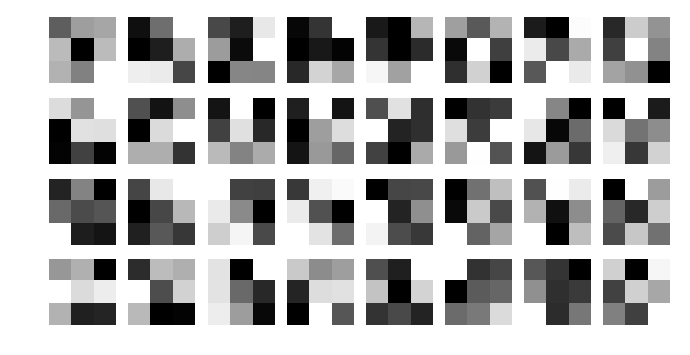

In [21]:
plt.rcParams['figure.figsize'] = (8.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Visualize
N_img_x = 4
N_img_y = 8

for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(net.params['conv1'][0].data[n_y * N_img_x + n_x, 0, :, :])
        plt.gca().axis('off')
plt.show()

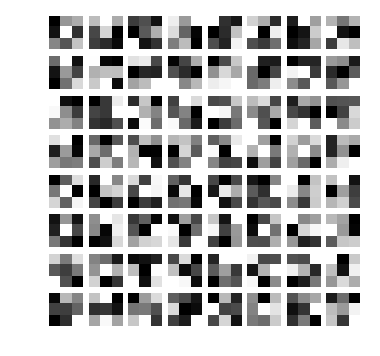

In [19]:
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Visualize
N_img_x = 8
N_img_y = 8

for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(net.params['conv2'][0].data[n_y * N_img_x + n_x, 0, :, :])
        plt.gca().axis('off')
plt.show()

In [11]:
def euclidean_loss(a, b):
    batch_size, num_labels = a.shape
    
    return np.sum((a-b)**2) / float(batch_size * 2)
    
# Make sure train error and validation error are as expected. 



input_size = 96

zero_pad = np.zeros(( batch_size - (train_size % batch_size), 1, input_size, input_size))
X_train = np.append(X_train_clean_cv, zero_pad, axis=0)
num_batches = X_train.shape[0] // batch_size

# X_train = np.random.randn(np.prod(X_train.shape)).reshape(X_train.shape)

zero_pad = np.zeros(( batch_size - (train_size % batch_size), num_labels))
y_train = np.append(y_train_clean_cv, zero_pad, axis=0)
# num_batches = 1
out_train = np.zeros((X_train.shape[0], 30) )


# print num_batches
# print X_train.shape[0]
# print train_size
# num_batches = 1

for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    net.blobs['data'].data[...] = X_train[it_range]
    
    out_test = net.forward(start='conv1')
    
    out = net.blobs['score'].data
    out_train[it_range, :] = out
    
#     print net.blobs['fc1'].data.shape
#     print net.blobs['score'].data.shape
#     print out_test
    if DEBUG_MESG:
        print "data"
        print net.blobs['data'].data.shape
        print net.blobs['data'].data[0:5, 0, 0:5, 0]

        print "conv1"
        print net.blobs['conv1'].data.shape
        print net.blobs['conv1'].data[0:5, 0, 0:5, 0]

        print "conv1 weights"
        print net.params['conv1'][0].data.shape
        print net.params['conv1'][0].data[0:2][0:5]

        print "\nconv1 biases"
        print net.params['conv1'][1].data.shape
        print net.params['conv1'][1].data[0:5]


        print "pool1"
        print net.blobs['pool1'].data.shape
        print net.blobs['pool1'].data[0:5, 0, 0:5, 0]


        print "conv2"
        print net.blobs['conv2'].data.shape
        print net.blobs['conv2'].data[0:5, 0, 0:5, 0]

        print "conv2 weights"
        print net.params['conv2'][0].data.shape
        print net.params['conv2'][0].data[0:2, 0:2, 0:5, 0]

        print "conv2 biases"
        print net.params['conv2'][1].data.shape
        print net.params['conv2'][0].data[0:2, 0:2, 0:5, 0]

        print "pool2"
        print net.blobs['pool2'].data.shape
        print net.blobs['pool2'].data[0:5, 0, 0:5, 0]

        print "fc1"
        print net.blobs['fc1'].data[0:5]

        print "score"
        print net.blobs['score'].data[0:2]
    


out_train_clean_cv = out_train[0:train_size]

train_error_2 = np.sum( (out_train_clean_cv - y_train_clean_cv) ** 2)
train_error =  train_error_2 / (2 * train_size)
print "train_error = ", train_error

train_rmse = np.sqrt( train_error_2 / (train_size * num_labels) )
print "train_rmse = ", train_rmse


train_error =  39.7012061242
train_rmse =  1.62688262482


In [12]:
batch_size = 64
num_batches = val_size/ batch_size
out_val_clean_cv = np.zeros_like(y_val_clean_cv)

for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    net.blobs['data'].data[...] = X_val_clean_cv[it_range]
    net.forward(start='conv1')
    out = net.blobs['score'].data
    out_val_clean_cv[it_range, :] = out
    
#     val_error += euclidean_loss(out, y_val_clean_cv[it_range])
# val_error = val_error / float(num_batches * batch_size)

val_error_2 = np.sum( (out_val_clean_cv - y_val_clean_cv) ** 2)
val_error =  val_error_2 / (2 * val_size)
print "val_error = ", val_error

val_rmse = np.sqrt( val_error_2 / (val_size * num_labels) )
print "val_rmse = ", val_rmse


val_error =  36.9340134921
val_rmse =  1.56916142131


[[  15 1007 1063  199]
 [ 840 1624  216 1053]
 [ 731 1355  317  450]
 [  63 1203  682  494]
 [1424 1493  864  691]
 [ 537  337 1553 1266]
 [  64  139  213 1112]
 [1548  275 1408 1545]
 [1536  871 1043   42]
 [ 250  883   22 1382]
 [ 298  644  740 1115]
 [ 725 1430  912  640]]


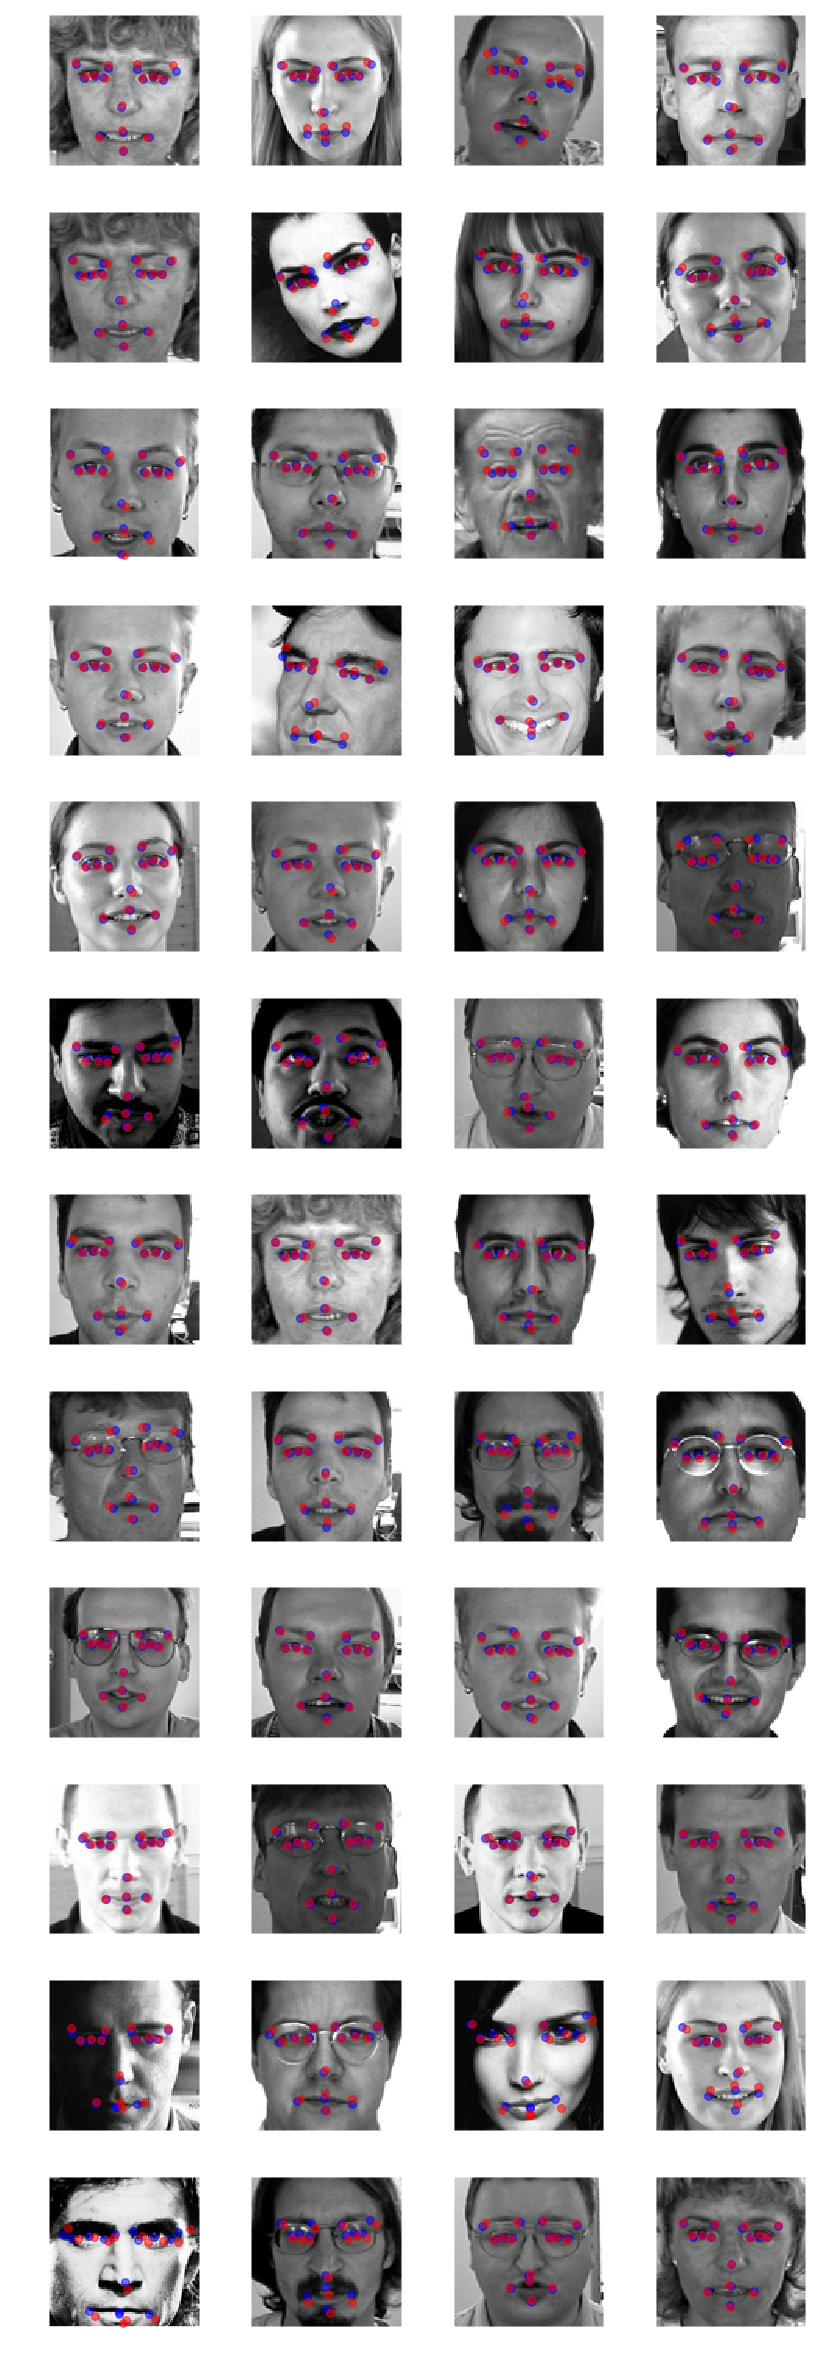

In [13]:
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Visualize
N_img_x = 12
N_img_y = 4
sel_idx = np.random.choice(X_train_clean_cv.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (10.0, 30.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_train_clean_cv[i].reshape(96, 96)
        b = y_train_clean_cv[i]
        b_x = b[0::2]
        b_y = b[1::2]
        
        o = out_train_clean_cv[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        # plt.scatter(b_x+3, b_y+3, s=30, alpha=0.5, color='black')
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()

[[ 351  181 1569  665]
 [ 541 1511   37  645]
 [ 869 1321 1386  801]
 [1072 1574  421 1080]]


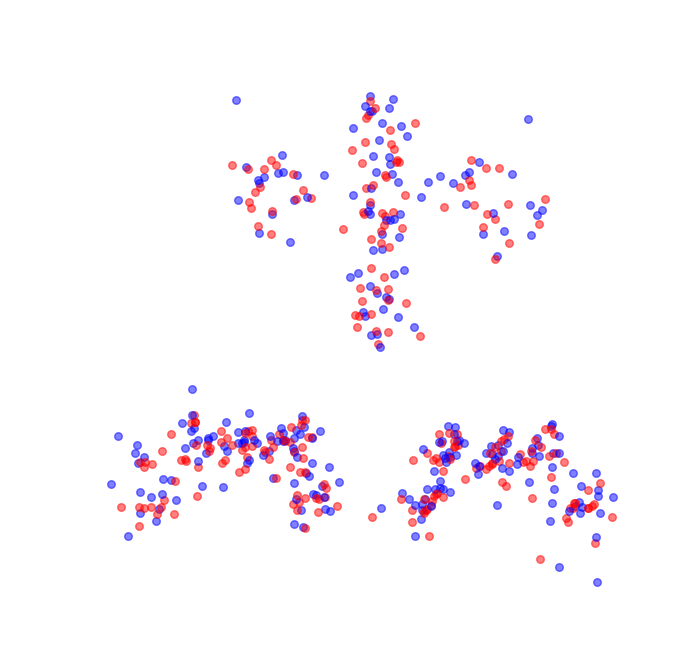

In [14]:
# check spread/ distribution


plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Visualize
N_img_x = 4
N_img_y = 4
sel_idx = np.random.choice(X_train_clean_cv.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_train_clean_cv[i].reshape(96, 96)
        b = y_train_clean_cv[i]
        b_x = b[0::2]
        b_y = b[1::2]
        
        o = out_train_clean_cv[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

#         plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
#         plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()

[[229 474  99 354]
 [307 334 151 429]
 [408 316  32 506]
 [359 483 233 433]]


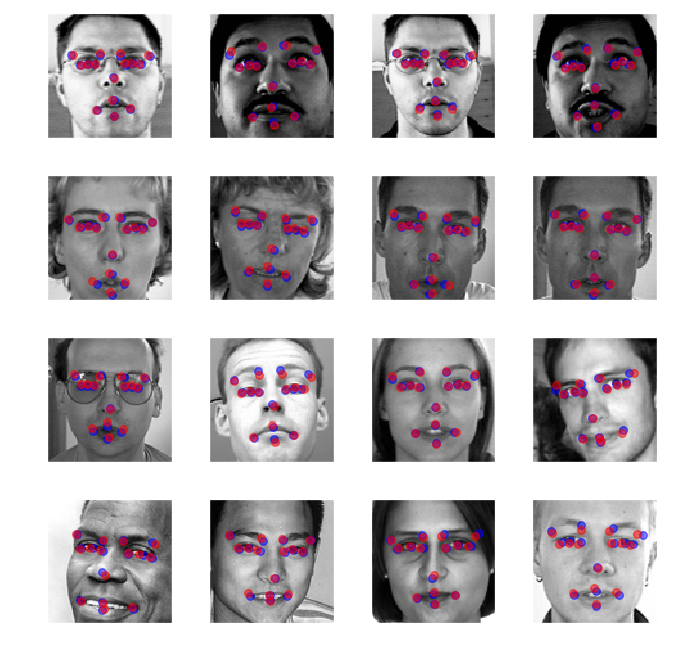

In [15]:
# Visualize
N_img_x = 4
N_img_y = 4
sel_idx = np.random.choice(X_val_clean_cv.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_val_clean_cv[i].reshape(96, 96)
        b = y_val_clean_cv[i]
        b_x = b[0::2]
        b_y = b[1::2]
        
        o = out_val_clean_cv[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()

In [16]:
import os.path
import pandas as pd

np_loaded_data_file = "../data/test_data.npz"
if not os.path.isfile(np_loaded_data_file):
    print "reading data ..."
    try:
        df=pd.read_csv('../data/test.csv', sep=',')
    except:
        print "Download test.csv from kaggle website"
    input_test = df.values
    
    X_test = input_test[:, 1]
    
    templist = []
    for i in range(X_test.shape[0]):
        templist.append([int(s) for s in X_test[i].split()])
    X_test = np.array(templist)
    
    X_test = X_test.astype(float)
    np.savez(np_loaded_data_file, X_test=X_test)
    print "saved %s ...." % np_loaded_data_file
else:
    print "training data %s exists. loading... " % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    X_test = npzfile['X_test']

training data ../data/test_data.npz exists. loading... 


In [17]:
X_test = X_test - np.mean(X_test)
num_test_images = X_test.shape[0]

input_size = 96
X_test = X_test.reshape(-1, 1, input_size, input_size)

zero_pad = np.zeros(( batch_size - (num_test_images % batch_size), 1, input_size, input_size))

X_test = np.append(X_test, zero_pad, axis=0)


num_batches = X_test.shape[0] // batch_size
# num_batches = 1
out_test = np.zeros((X_test.shape[0], 30) )

for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    net.blobs['data'].data[...] = X_test[it_range]
    net.forward(start='conv1')
    out = net.blobs['score'].data
    out_test[it_range, :] = out
    
out_test = out_test[0:num_test_images]


[[ 600 1295  117   65]
 [ 543  573  819  548]
 [1455   68 1252 1552]
 [  43  176  621  706]
 [  62 1477 1463  500]
 [1383  932  333 1303]
 [ 972  416 1117 1775]
 [1281 1599 1653 1344]
 [ 909 1637 1125  555]
 [ 835 1019  881  926]
 [1321 1678  955 1147]
 [ 811 1695  234  708]]


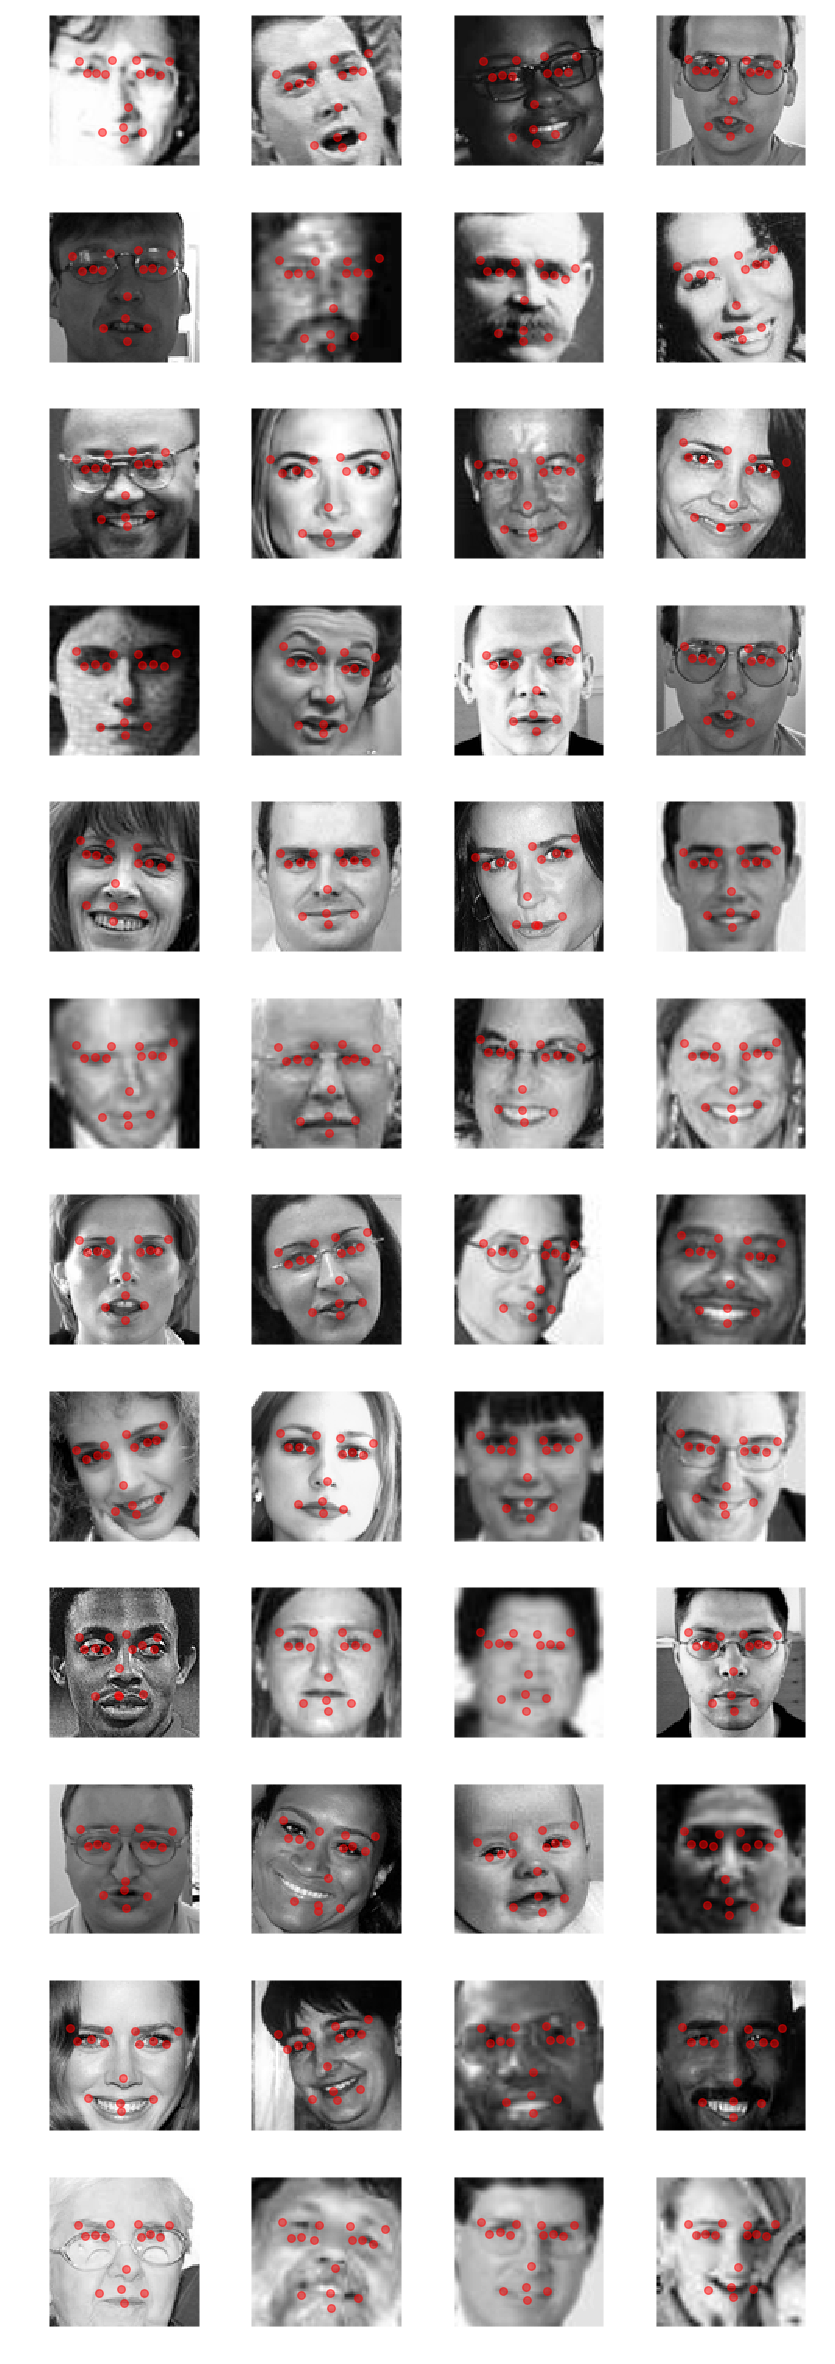

In [18]:
# Visualize
N_img_x = 12
N_img_y = 4
sel_idx = np.random.choice(X_test.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (10.0, 30.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_test[i].reshape(96, 96)
        
        
        o = out_test[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()

In [19]:
feature_label_lookup_table = dict(zip(feature_labels[0:30], range(30)))
try:
    df=pd.read_csv('../data/IdLookupTable.csv', sep=',')
except:
    print "Download IdLookupTable.csv from kaggle website"
input_test = df.values

row_ids = input_test[:, 0]
image_ids = input_test[:, 1]
feature_names = input_test[:, 2]
locations = np.zeros(image_ids.shape[0])


for row_id, image_id, feature_name in zip(row_ids, image_ids, feature_names):
    loc_temp = out_test[image_id-1, feature_label_lookup_table[feature_name]]
    if loc_temp < 0:
        loc_temp = 0
    elif loc_temp >96:
        loc_temp = 96
            
    locations[row_id-1] = loc_temp
    

df_save = pd.DataFrame(index=row_ids, data=locations, columns=['Location'])
df_save.to_csv('../data/submission_20161023.csv')